Data shape: (200, 15)
Test loss=0.0013, mae=0.0276


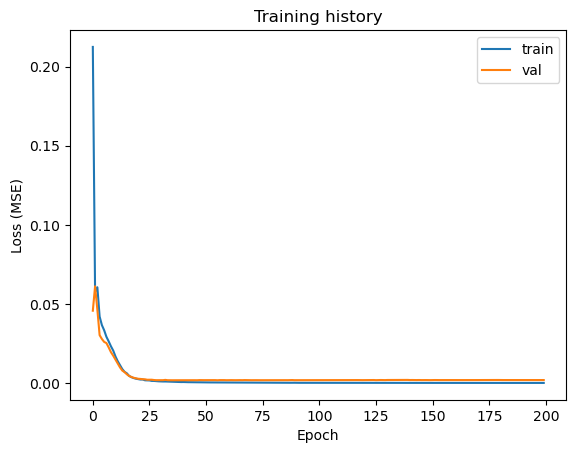

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


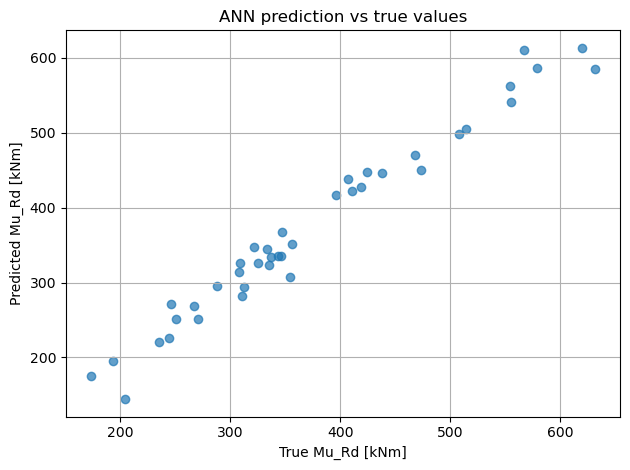

In [1]:
# Step 18 — Simple ANN for Mu_Rd prediction (test run)

from pathlib import Path
import pandas as pd, numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

ROOT = Path.cwd().parent if Path.cwd().name.lower()=="notebooks" else Path.cwd()
DATA = ROOT / "data"

# ---- Load dataset ----
df = pd.read_csv(DATA / "beam_samples_small.csv")
print("Data shape:", df.shape)

# ---- Select inputs and target ----
X_cols = ["b_mm","h_mm","cover_mm","span_mm",
          "f_ck_MPa","f_y_MPa","As_tens_mm2","As_comp_mm2",
          "g_k_kNm","q_k_kNm"]
y_col  = "Mu_Rd_kNm"

X = df[X_cols].values
y = df[[y_col]].values

# ---- Train/val/test split ----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- Scale features ----
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_s = x_scaler.fit_transform(X_train)
X_test_s  = x_scaler.transform(X_test)
y_train_s = y_scaler.fit_transform(y_train)
y_test_s  = y_scaler.transform(y_test)

# ---- Define ANN model ----
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(X_cols),)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

# ---- Train ----
hist = model.fit(X_train_s, y_train_s, validation_split=0.2,
                 epochs=200, batch_size=16, verbose=0)

# ---- Evaluate ----
loss, mae = model.evaluate(X_test_s, y_test_s, verbose=0)
print(f"Test loss={loss:.4f}, mae={mae:.4f}")

# ---- Plot training curves ----
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("Training history")
plt.show()

# ---- Predict and compare ----
y_pred_s = model.predict(X_test_s)
y_pred = y_scaler.inverse_transform(y_pred_s)

plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("True Mu_Rd [kNm]")
plt.ylabel("Predicted Mu_Rd [kNm]")
plt.title("ANN prediction vs true values")
plt.grid(True)
plt.tight_layout()
plt.show()


Model saved to: C:\Users\amirn\thesis-rc-beam\reports\models\ann_mu_rd_model.keras
Prediction table saved to: C:\Users\amirn\thesis-rc-beam\reports\tables\mu_predictions.csv
Correlation (R): 0.9852


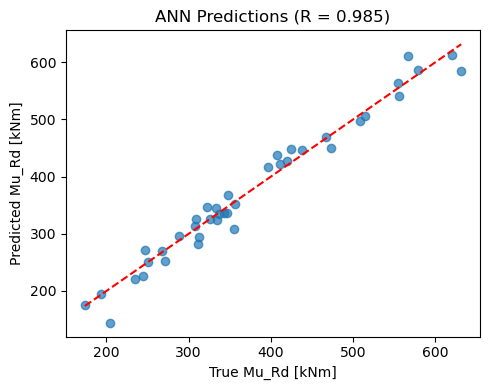

In [4]:
from pathlib import Path
import numpy as np
import pandas as pd

ROOT = Path.cwd().parent if Path.cwd().name.lower()=="notebooks" else Path.cwd()
REPORTS = ROOT / "reports"
MODEL_DIR = REPORTS / "models"
TABLES_DIR = REPORTS / "tables"
for d in [MODEL_DIR, TABLES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ---- Save the model weights ----
model_path = MODEL_DIR / "ann_mu_rd_model.keras"
model.save(model_path)
print("Model saved to:", model_path)

# ---- Save prediction comparison table ----
pred_table = pd.DataFrame({
    "Mu_true_kNm": y_test.flatten(),
    "Mu_pred_kNm": y_pred.flatten()
})
pred_csv = TABLES_DIR / "mu_predictions.csv"
pred_table.to_csv(pred_csv, index=False)
print("Prediction table saved to:", pred_csv)

# ---- Compute correlation ----
corr = np.corrcoef(y_test.flatten(), y_pred.flatten())[0,1]
print(f"Correlation (R): {corr:.4f}")

# ---- Quick visual summary ----
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True Mu_Rd [kNm]")
plt.ylabel("Predicted Mu_Rd [kNm]")
plt.title(f"ANN Predictions (R = {corr:.3f})")
plt.tight_layout()
plt.show()


Model reloaded successfully
   Mu_true_kNm  Mu_pred_kNm
0   288.416951    295.35916
1   321.981222    347.40717
2   619.758890    613.39800
3   243.981759    225.72426
4   578.569954    587.16254


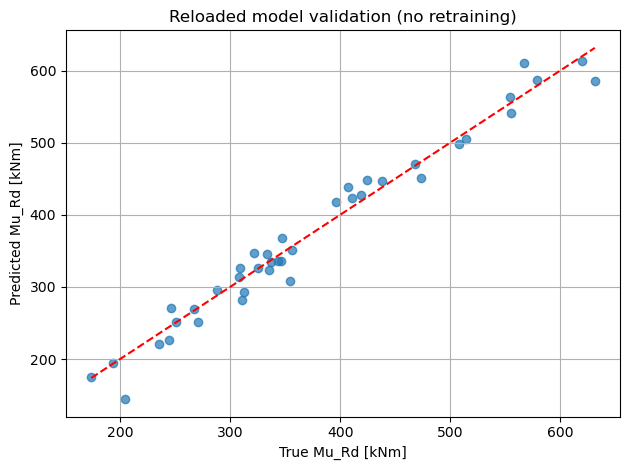

In [5]:
# Step 20 — Reload saved model and verify reproducibility

from pathlib import Path
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path.cwd().parent if Path.cwd().name.lower()=="notebooks" else Path.cwd()
MODEL_DIR = ROOT / "reports" / "models"
TABLES_DIR = ROOT / "reports" / "tables"

# ---- Load model ----
reloaded_model = tf.keras.models.load_model(MODEL_DIR / "ann_mu_rd_model.keras")
print("Model reloaded successfully")

# ---- Load prediction table (saved results) ----
pred_table = pd.read_csv(TABLES_DIR / "mu_predictions.csv")
print(pred_table.head())

# ---- Simple comparison plot ----
plt.scatter(pred_table["Mu_true_kNm"], pred_table["Mu_pred_kNm"], alpha=0.7)
plt.plot([pred_table["Mu_true_kNm"].min(), pred_table["Mu_true_kNm"].max()],
         [pred_table["Mu_true_kNm"].min(), pred_table["Mu_true_kNm"].max()], "r--")
plt.xlabel("True Mu_Rd [kNm]")
plt.ylabel("Predicted Mu_Rd [kNm]")
plt.title("Reloaded model validation (no retraining)")
plt.grid(True)
plt.tight_layout()
plt.show()
